# 学习理论 Learning Theory

本节包括以下内容：
1. 偏差/方差权衡 Bias/variance tradeoff
2. 基础定理 Preliminaries
3. 有限假设的情况 The case of finite $\mathcal{H}$
4. 无限假设的情况 The case of infinite $\mathcal{H}$


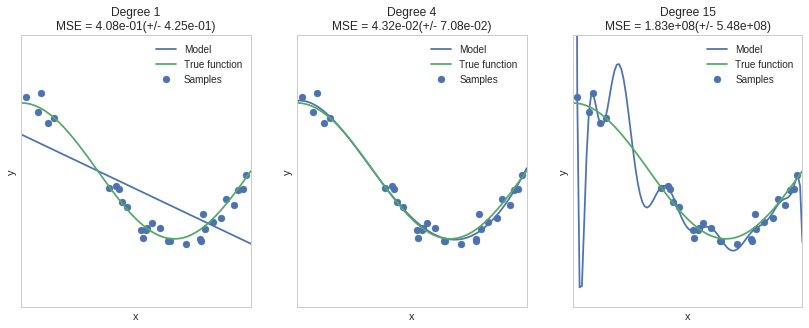

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

sns.set_style('whitegrid')

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

### 1. 偏差/方差权衡 Bias/Variance Tradeoff

在讨论线性回归模型时，我们比较过使用一阶特征和高阶特征的模型。使用最高 $15$ 阶非常准确地根据训练集中给定 $x$ 预测出了 $y$，然而我们显然无法指望这个模型对于不在训练集中的新数据表现良好。换句话说，从训练集中学得的这个模型，泛化能力很差。一个假设的**泛化误差 generalization error**是指其对于非训练集数据的期望误差。

左侧的模型和右侧一样，都有很大的泛化误差，但两个模型的情况又不尽相同。考虑到 $y$ 和 $x$ 的关系并不是线性的，即使我们用非常大的数据量去训练，这个线性模型依然无法捕捉数据的真实结构。非正式地，我们定义模型的**偏差 bias**为当用巨大甚至无限的数据量训练模型后的期望泛化误差。因而，上图中的线性模型，有着非常大的偏差，从而可能对数据集欠拟合。

除去偏差外，泛化误差还包括另一个部分，模型拟合的**方差 variance**。以上图最右侧的 $15$ 阶模型为例，有很大可能，我们拟合出模型的模式，仅仅存在于非常小而有限的训练集中，并不真正反应全体 $x$ 和 $y$ 的关联。这时，模型的巨大泛化误差，主要来自于方差，模型对数据集过拟合了。

通常，偏差和方差之间存在权衡取舍。如果模型过于简单，只有少数几个参数，那么它可能有高偏差低方差；反之，如果模型过于复杂，参数非常多，那么它可能有高方差低偏差。在上图的例子中，$4$ 阶的模型是最优解。

### 2. 基础定理 Preliminaries

学习理论试图解决以下几个问题：
1. 规范化地描述偏差/方差权衡，并最终讨论模型选择，例如自动地选择线性回归特征的阶数。
2. 机器学习最终关系的目标其实是泛化误差，但绝大多数模型都在针对训练集进行拟合。那么训练集误差和泛化误差有什么关联？
3. 能否严格证明，在某些条件满足的前提下，学习算法将会是有效的。

两个引理：
1. 布尔不等式（Boole's inequality，也称union bound）：令 $A_1, A_2,...,A_k$ 表示 $k$ 个不同的事件，那么
$$ P(A_1 \cup \cdots \cup A_k) \leq P(A_1) + \cdots + P(A_k) $$
$k$ 中任意某些事件发生的概率，至多等于每个事件发生的概率之和。 
2. 霍夫丁不等式（Hoeffding's inequality）：令 $Z_1, Z_2,...,Z_m$ 表示 $m$ 个独立同分布随机变量，均来自于以 $\phi$ 为参数的伯努利分布。也即，$P(Z_i=1)=\phi, P(Z_i=0)=1-\phi$。令 $\hat{\phi}=(1/m)\sum_{i=1}^m Z_i$ 为这些随机变量的均值，$\gamma>0$ 为任一常量，那么
$$ P(|\phi-\hat{\phi}|>\gamma) \leq 2e^{-2{\gamma}^2m} $$
如果我们用 $m$ 个伯努利随机变量的均值来预测伯努利分布的参数，只要 $m$ 足够大，那么预测值远离真实值的概率就非常小。

根据这两个引理，可以证明学习理论中一些重要的结果。

为简化说明，这里将聚焦于二元分类问题，分类的标签记做 $y \in \{0,1\}$。不过这里的证明，同样适用于回归和多元分类问题。

假设给定训练集 $S = \{(x^{(i)},y^{(i)});i=1,...,m \}$，样本大小为 $m$，并且训练集中的每一个训练样本 $(x^{(i)},y^{(i)}$ 均来自于某个独立同分布的概率分布 $D$。对于一个假设 $h$，定义**训练误差 training error**（在学习理论中，也被称为**经验风险 empirical risk**，或**经验误差 empirical error**）为
$$ \hat{\epsilon}(h) = \frac{1}{m}\sum_{i=1}^m 1\{h(x^{(i)}) \neq y^{(i)}\} $$
也即被 $h$ 错误分类的训练样本占比。当需要显式表示训练误差与训练集的关系时，也可以写做 $\hat{\epsilon}_S (h)$。同样地，定义泛化误差为
$$ \epsilon(h) = P_{(x,y) \sim D}(h(x) \neq y) $$
也即从概率分布 $D$ 获得一个新样本 $(x,y)$，$h$ 错误分类的概率。

注意到，这里下设训练集数据来自于计算泛化误差的同一个概率分布 $D$，这个假设有时被称为**PAC假设**（probably approximately correct假定包含了一组假设，其中最重要的假设是，训练集和测试集的分布相同，每个训练样本相互独立）。

考虑线性分类的情况，令 $h_\theta(x)=1\{\theta^Tx \geq 0\}$。估计参数 $\theta$ 的一个方式，就是最小化训练误差，计算
$$ \hat{\theta} = arg \min_{\theta} \hat{\epsilon}(h_\theta) $$
这个过程称为**经验风险最小化 empirical risk minimization(EMR)**，通过这个学习算法随之得到的假设函数记为 $\hat{h}=h_{\hat{\theta}}$。EMR是最基础的学习算法，本节内容将围绕EMR展开。（逻辑回归算法，也可以看做是EMR的一种估计）。

在学习理论的研究中，最好能剥离开如何进行参数估计、是否使用线性分类器等技术问题。于是，定义**假设类** $\mathcal{H}$，表示学习算法考虑的所有分类器。对于线性分类器来说，$\mathcal{H} = \{h_\theta:h_\theta(x)=1\{\theta^Tx \geq 0\},\theta \in \mathbb{R}^{n+1} \}$ 就表示了输入定义域 $\mathcal{X}$ 上的所有线性分类器。更广泛地考虑，如果这里使用的是神经网络，那么 $\mathcal{H}$ 表示的就是某种神经网络结构。

经验风险最小化算法，于是就可以表示成在一组假设 $\mathcal{H}$ 中挑选训练误差最小假设的过程：
$$ \hat{h} = arg \min_{h \in \mathcal{H}} \hat{\epsilon}(h) $$

### 3. 有限假设的情况 The Case of Finite $\mathcal{H}$

首先，考虑有限假设的情况，令 $\mathcal{H}=\{h_1,...,h_k\}$ 包含 $k$ 个假设函数。因此，$\mathcal{H}$ 就是 $k$ 个函数的集合，每个函数分别从 $\mathcal{X}$ 映射到 $\{0,1\}$，而EMR将会从这 $k$ 个函数中挑选训练误差最小的 $\hat{h}$。

我们希望给出 $\hat{h}$ 函数泛化误差的保证，这将包括以下两个步骤：
1. 证明对所有假设函数 $h$，$\hat{\epsilon}(h)$ 都是 $\epsilon(h)$ 的可靠估计。
2. 证明 $\hat{h}$ 的泛化误差存在上界。

先随便取某个假设函数 $h_i \in \mathcal{H}$，考虑这样一个伯努利分布的随机变量 $Z$：抽样 $(x,y) \sim D$，令 $Z=1\{h_i(x) \neq y\}$，即从总体中抽出一个样本，$Z$ 表示 $h_i$ 是否错误分类。类似地，对于训练集中的训练样本，定义 $Z_j=1\{h_i(x^{(i)}) \neq y^{(i)}\}$。由于训练集是独立同分布地抽样于 $D$，从而 $Z$ 和 $Z_j$ 具有相同的分布。

随机抽样的样本被错误分类的概率 $\epsilon(h_i)$ 正是 $Z$（以及 $Z_j$）的期望值。另外，训练误差可以写做
$$ \hat{\epsilon}(h_i)=\frac{1}{m}\sum_{j=1}^m Z_j $$
利用霍夫丁不等式，有
$$ P(|\epsilon(h_i) - \hat{\epsilon}(h_i)| > \gamma) \leq 2e^{-2{\gamma}^2m} $$

这个结果表明，对于 $h_i$ 这个特定的假设函数，当 $m$ 足够大时，训练误差将会以很大的概率接近泛化误差。但我们不仅仅需要某个特定的假设具有这个特性，我们希望对于所有假设 $h \in \mathcal{H}$，训练误差都大概率接近对应的泛化误差。为了证明这一点，令 $A_i$ 表示事件 $|\epsilon(h_i) - \hat{\epsilon}(h_i)| > \gamma$，上面的结论可以写成 $\forall i \in k. P(A_i) \leq 2e^{-2{\gamma}^2m}$。利用布尔不等式，有
$$
\begin{split}
P(\exists h \in \mathcal{H}.|\epsilon(h_i) - \hat{\epsilon}(h_i)|>\gamma) &= P(A_1 \cup \cdots \cup A_k) \\
&\leq \sum_{i=1}^k P(A_i) \\
&\leq \sum_{i=1}^k 2e^{-2{\gamma}^2m} \\
&= 2ke^{-2{\gamma}^2m}
\end{split}
$$
上面的不等式，两边同时减 $1$，有
$$
\begin{split}
P(\neg\exists h \in \mathcal{H}.|\epsilon(h_i) - \hat{\epsilon}(h_i)|>\gamma) &= P(\forall h \in \mathcal{H}.|\epsilon(h_i) - \hat{\epsilon}(h_i)| \leq \gamma) \\
&\geq 1-2ke^{-2{\gamma}^2m}
\end{split}
$$
即，至少有 $1-2ke^{-2{\gamma}^2m}$ 的概率保证对所有 $h \in \mathcal{H}$，$\hat{\epsilon}(h)$ 将在 $\epsilon(h)$ 的上下 $\gamma$ 的范围内。由于对所有 $h \in \mathcal{H}$ 生效，这个结果称为一致收敛。

上面，我们在固定 $m$ 和 $\gamma$ 值的前提下，给定了训练误差和泛化误差接近这一事件概率的下界。这里实际上有三个值是我们关心的，$m, \gamma$ 以及训练误差和泛化误差不接近的概率 $\delta$。同样地，我们可以固定另外一组值，得到另一个变量的边界。

比如，给定 $\gamma$ 和 $\delta > 0$，$m$ 需要有多大，才能保证训练误差以 $1-\delta$ 的概率在泛化误差上下 $\gamma$的范围内？令 $\delta=2ke^{-2{\gamma}^2m}$，代入可以解得
$$ m \geq \frac{1}{2\gamma^2}log\frac{2k}{\delta} $$
这个下界提出了对训练样本数量的要求，对于某个算法而言，训练样本数需要达到这个数量才能保证算法的性能，这里的 $m$ 也称为算法的样本复杂度。其中最关键的特性是，训练样本的数量要求，是假设数量 $k$ 的对数级数。

类似地，也可以固定 $m,\delta$，求解 $\gamma$。从而以 $1-\delta$ 的概率，对于所有 $h \in \mathcal{H}$，有
$$ |\hat{\epsilon}(h) - \epsilon(h)| \leq \sqrt{\frac{1}{2m}log\frac{2k}{\delta}} $$

这样，当一致收敛约束得到保证时，挑选 $\hat{h}=arg \min_{h \in \mathcal{H}} \hat{\epsilon}(h)$ 的泛化误差如何呢？定义 $h^*=arg \min_{h \in \mathcal{H}}\epsilon(h)$，即所有假设集合 $\mathcal{H}$ 中的最优假设，有
$$
\begin{split}
\epsilon(\hat{h}) &\leq \hat{\epsilon}(\hat{h})+\gamma \\
&\leq \hat{\epsilon}(h^*)+\gamma \\
&\leq \epsilon(h^*)+2\gamma \\
\end{split}
$$
第一行用到了一致收敛约束 $|\epsilon(\hat{h})-\hat{\epsilon}(\hat{h})|\leq \gamma$；第二行，由于 $\hat{h}$ 是根据训练集挑选的训练误差最小的假设，所以其训练误差小于任何其它假设的训练误差，包括 $h^*$；第三行再次使用一致性约束 $|\hat{\epsilon}(h^*) - \epsilon(h^*)|\leq \gamma$。从而，当一致性约束得到保证时，$\hat{h}$ 的泛化误差至多比最优假设的泛化误差大 $2\gamma$。

**定理** 设 $|\mathcal{H}|=k$，固定 $m, \delta$，那么至少以 $1-\delta$的概率，有
$$ \epsilon(\hat{h}) \leq (\min_{h \in \mathcal{H}}\epsilon(h)) + 2\sqrt{\frac{1}{2m}log\frac{2k}{\delta}} $$

这个定理在一定程度上也解释了偏差/方差权衡。假设我们已经有一组假设类 $\mathcal{H}$，目前在考虑将其替换为更广泛的假设类 $\mathcal{H}^\prime \supseteq \mathcal{H}$（比如算法不变，但使用高阶特征）。如果切换到 $\mathcal{H}^\prime$，第一项 $\min_h\epsilon(h)$ 会下降或不变（在更大一组假设函数中取最小值），因此，通过在更大的假设类中学习，模型的偏差会下降。与此同时，由于 $k$ 的上升，第二项会提升，这个上升对应着模型的方差。

**推论** 设 $|\mathcal{H}|=k$，固定 $\delta, \gamma$，要使 $\epsilon(\hat{h}) \leq (\min_{h \in \mathcal{H}}\epsilon(h)) + 2\gamma$ 得到至少 $1-\delta$ 的概率保证，需要
$$ 
\begin{split}
m &\geq \frac{1}{2\gamma^2}log\frac{2k}{\delta} \\
&= O(\frac{1}{\gamma^2}log\frac{k}{\delta})
\end{split}
$$

### 4. 无限假设的情况 The case of infinite $\mathcal{H}$

有限假设的情况已经推导出了相应的定理。但许多假设类，包括以实数为参数的算法（比如线性分类），实际上包含着无限个假设函数。有限假设的相应定理，需要相应的修正，才能推广到无限假设的情况。

设想假设类 $\mathcal{H}$ 包含 $d$ 个实数参数。在IEEE标准中，计算机使用64位来表示对于一个双精度浮点数，这意味着对于我们的学习算法而言，表示一组参数需要 $64d$ 位。从而，假设类至多可以包含 $k=2^{64d}$ 种不同的假设函数。根据上一节最后的推论，要至少以 $1-\delta$ 的概率保证 $\epsilon(\hat{h}) \leq \epsilon(h^*) + 2\gamma$，需要满足 $m \geq O(\frac{1}{\gamma^2})log\frac{2^{64d}}{\delta}=O(\frac{d}{\gamma^2}log\frac{1}{\delta})=O_{\gamma,\delta}(d)$。所以，无限假设算法所需要的训练样本数量，至多是其模型参数数量的线性级别。

由于上面的论证依赖于64位浮点数的设定，论证并不十分严格，但得出的结论大体上是正确的。如果算法的目标是最小化训练误差，那么为了对有 $d$ 个参数的模型学习出较好的效果，普遍来说至少需要和 $d$ 线性级别的训练样本。

（需要注意的是，这里证明的是经验风险最小化算法的情况。因此，算法的样本复杂度和参数线性相关的这一结论，并不总能直接应用于所有其它判别学习算法。但如果判别学习算法在最小化训练误差，或者最小化某个训练误差的近似值，这个结论就是成立的）

上面的论证，另一个不严格的地方在于，它依赖于 $\mathcal{H}$ 的参数化表示。直觉上看，结论应该和参数无关：我们之前将线性分类器表示为 $h_\theta(x)=1\{\theta_0+\theta_1x_1+\cdots+\theta_nx_n \geq 0\}$，其中包括 $n+1$ 个参数 $\theta_0,\cdots,\theta_n$。但线性分类器也可以表示为 $h_{u,v}(x)=1\{(u_0^2-v_0^2)+(u_1^2-v_1^2)x_1+\cdots+(u_n^2-v_n^2)x_n \geq 0\}$，这样就有了 $2n+2$ 个参数 $u_i,v_i$。但其实，二者都表示同一个假设类 $\mathcal{H}$：即 $n$ 维的线性分类器。

为了修正对参数化表示的依赖，需要引入以下一些概念：

给定一个集合 $S=\{x^{(i)},\cdots,x^{(d)}\}$ 包含一系列点 $x^{(i)} \in \mathcal{X}$，如果 $\mathcal{H}$ 能够对 $S$ 进行分类打标签，则称 $\mathcal{H}$ 可以**打散 shatter** $S$。可以分类打标签的意义是：对于任意的一组标签 $\{y^{(1)},\cdots,y^{(d)}\}$，都存在 $h \in \mathcal{H}$ 使得对所有 $i=1,...,d$，$h(x^{(i)})=y^{(i)}$。

给定一个假设类 $\mathcal{H}$，定义其**VC维 Vapnik-Chervonenkis dimension**，记做 $VC(\mathcal{H})$，为 $\mathcal{H}$ 所能打散的最大集合所包含的元素数量。（如果 $\mathcal{H}$ 能打散任意大的集合，那么$VC(\mathcal{H})=\infty$）

根据VC维的定义，要证明 $VC(\mathcal{H})$ 至少是 $d$，只需要找到一组大小为 $d$ 且 $\mathcal{H}$ 能打散的集合即可。

**定理** 给定 $\mathcal{H}$，令 $d=VC(\mathcal{H})$，那么以至少 $1-\delta$ 的概率，对于所有 $h \in \mathcal{H}$，有
$$ |\epsilon(h)-\hat{\epsilon}(h)| \leq O(\sqrt{\frac{d}{m}log\frac{m}{d}+\frac{1}{m}log\frac{1}{\delta}}) $$

换言之，只要假设类的VC维是有限的，随着 $m$ 的增大，就会达到一致收敛。从而，存在泛化误差关于训练误差的上界。同样，有以下推论

**推论** 要使 $|\epsilon(h)-\hat{\epsilon}(h)| \leq \gamma$ 对于所有 $h \in \mathcal{H}$ 至少以 $1-\delta$ 的概率成立，需要 $m=O_{\gamma,\delta}(d)$

换言之，要使假设类 $\mathcal{H}$ 学习效果足够好，需要训练集样本数是其VC维的线性数量级。事实上，对于大多数假设类来说，其VC维大致与其参数数量线性相关。从而，对于最小化训练误差的算法来讲，其所需要的训练集样本数，大约是和算法的参数数量线性相关的。